This notebook contains scripts to compare plume model codes with differences in the choice of conserved variable


In [1]:
import importlib
import PlumeModel
from preprocessors import preprocess_ARMBE, preprocess_Nauru
import time
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr

In [2]:
importlib.reload(PlumeModel)

<module 'PlumeModel' from '/home/fiaz/plume_model/PlumeModel.py'>

In [3]:
input_dir = Path('/neelin2020/ARM/CACTI/')
time_str = 'corinterpolatedsondeM1.c1.20181018'
fil_interpsonde = [str(i) for i in (input_dir/'interpsonde').glob(time_str+'*.nc')]
fil_interpsonde.sort()
fil_interpsonde

['/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181018.000030.nc']

(1000.0, 0.0)

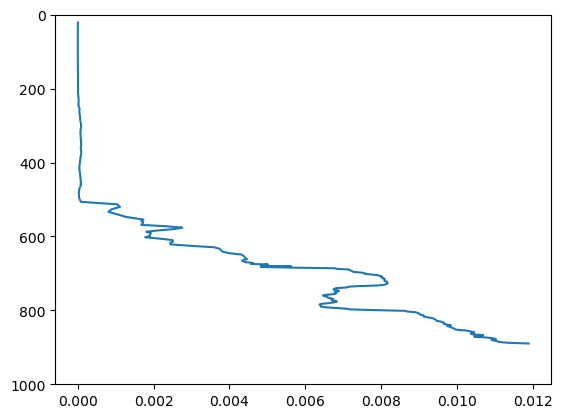

In [4]:
# select a single profile for testing
import xarray as xr
def preprocess_interpsonde_CACTI(fils):
    ds = xr.open_mfdataset(fils)
    ts = slice('2018-10-18T17:00:00', '2018-10-18T17:30:00')
    ds = ds.sel(time = ts)
    return ds.temp.values + 273, ds.sh.values, ds.bar_pres.values * 1e1, ds.time.values

ds = preprocess_interpsonde_CACTI(fil_interpsonde)
plt.plot(ds[1][0, :], ds[2][0, :])
plt.ylim(1000, 0)


In [5]:
output_dir = './'  # directory to save the output files
output_file_name = 'plume_props_CACTI_test_theta_il0'  # name of the output file
kwargs = dict(fils = fil_interpsonde, 
              preprocess = preprocess_interpsonde_CACTI,
              output_file_name = output_file_name, 
              output_dir = output_dir, 
              launch_opt = 'specified',  # specified level or from the surface
              launch_level = 885,        # launch level in hPa
              rain_out = 1e2,            # rain out threshold (kg/kg)
              conserved = 1,            # 1: theta_il, 2: theta_e
              DIB_mix_upper = 450,       # upper level for DIB mixing; no mixing above this level
              microphysics = 2, 
              mix_opt = 'NOMIX',         # mixing option: 'DIB' or 'NOMIX'
              C0 = 0.2, 
              qsat_opt = 1)

pm = PlumeModel.PlumeModel(**kwargs)

pm.preprocess_data()
pm.mixing_coefficients()
stime = time.time()
pm.run_plume(mix = pm.mix_opt)
print(f'Done. Took {time.time()-stime: .3f} seconds')
pm.postprocess_save()

RUNNING NOMIX PLUME COMPUTATION
Done. Took  0.017 seconds
SAVING FILE
File saved as plume_props_CACTI_test_theta_il0.nc


In [16]:
importlib.reload(PlumeModel)
kwargs.update(output_file_name = 'plume_props_CACTI_test_mse-ib')
jp_pm = PlumeModel.JPPlume(**kwargs)
jp_pm.prepare_jp_plume()
jp_pm.lift_parcel_adiabatic(jp_pm.fracent, jp_pm.prate)
jp_pm.postprocess_save()

SAVING FILE
File saved as plume_props_CACTI_test_mse-ib.nc


Test theta_il Inversion

In [12]:
np.gradient(T_mse_ib, z0[:11]) * 1e3, np.gradient(T_theta_il, z0[:11]) * 1e3

(array([-9.66880479, -9.5110816 , -6.77673135, -4.19770535, -4.20844535,
        -4.21933422, -4.23037345, -4.24157061, -4.25292624, -4.26443862,
        -4.27025077]),
 array([-9.53736751, -9.45019002, -6.98435779, -4.60541752, -4.61902316,
        -4.63253616, -4.64597025, -4.65960078, -4.67420272, -4.68746274,
        -4.69336734]))

In [13]:
# Code to test the lifted parcel temperature
# import ECAPE_FUNCTIONS
# importlib.reload(ECAPE_FUNCTIONS)
# from ECAPE_FUNCTIONS import lift_parcel_adiabatic
# ds0 = xr.open_dataset('plume_props_CACTI_test_mse-ib.nc').isel(time = 0)
# T_jp, *_ = lift_parcel_adiabatic(ds0.T_env.values, ds0.lev.values * 1e2, ds0.q_env.values, jp_pm.ind_launch[0], 0, 0, jp_pm.z[0,:], jp_pm.T1, jp_pm.T2)

In [9]:
fil_out = pm.output_file_name.with_suffix('.nc')
ds = xr.open_dataset(fil_out)
files = [i for i in Path(output_dir).glob('*plume_props_CACTI_test_*.nc')]
ds = {i.stem.split('test_')[-1] : xr.open_mfdataset(i) for i in files}
# remove keys
[ds.pop(k) for k in ['theta_il', 'theta_e', 'theta_il2']]
ds.keys()

dict_keys(['theta_il1', 'theta_il0', 'mse-ib'])

In [10]:
ds.keys()

dict_keys(['theta_il1', 'theta_il0', 'mse-ib'])

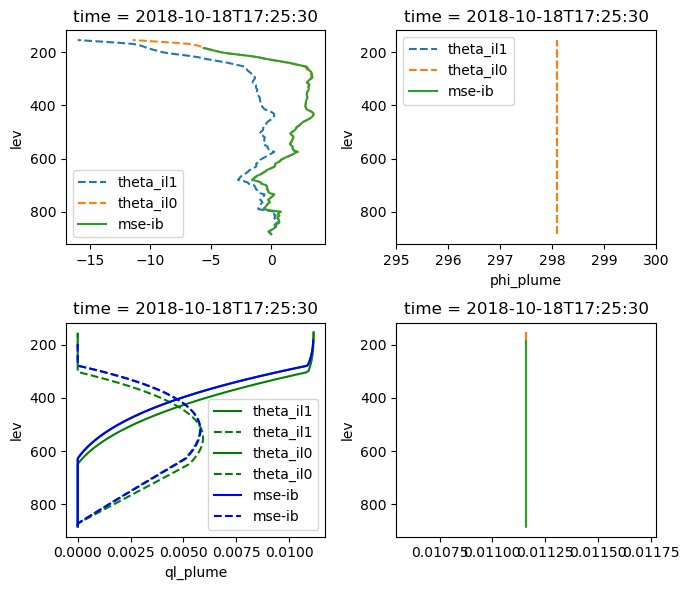

In [11]:
plot_Tdiff = lambda ds, it, ax, ls, label: (ds.T_plume - ds.T_env).isel(time = it).plot(y = 'lev', yincrease = False, 
                                                                                    ax = ax, label = label, linestyle = ls)
qt_plume = lambda ds: ds.qi_plume + ds.ql_plume + ds.q_plume

it = 25
fig, axx = plt.subplots(2, 2, figsize = (7, 6))

ax = axx[0, 0]
for k in ds.keys():
    if k == 'mse-ib':
        ls = '-'
    else:
        ls = '--'
    plot_Tdiff(ds[k], it, ax, ls, label = k)
ax.legend()

ax = axx[0, 1]
for k in ds.keys():
    if k == 'mse-ib':
        ls = '-'
    else:
        ls = '--'
    ds[k].phi_plume.isel(time = it).plot(y = 'lev', yincrease = False, ax = ax, label = k, linestyle = ls)
ax.legend()
ax.set_xlim(295, 300)

ax = axx[1, 0]
for k in ds.keys():

    if k == 'mse-ib':
        c = 'blue'
        a = 1.0
    elif k == 'theta_il':
        c = 'red'
        a = 0.5
    else:
        c = 'green'
        a = 1.0

    ds[k].qi_plume.isel(time = it).plot(y = 'lev', yincrease = False, ax = ax, label = k, color = c, alpha = a)
    ds[k].ql_plume.isel(time = it).plot(y = 'lev', yincrease = False, ax = ax, label = k, linestyle = '--', color = c, alpha = a)

ax.legend()
ax = axx[1, 1]
for k in ds.keys():
    qt_plume(ds[k]).isel(time = it).plot(y = 'lev', yincrease = False, ax = ax, label = k)
plt.tight_layout()

SAVE = False
if SAVE:
    plt.savefig('./plume_computations_compare.pdf', bbox_inches = 'tight', format = 'pdf', 
                dpi = 150)

Text(0.5, 0, 'K/km')

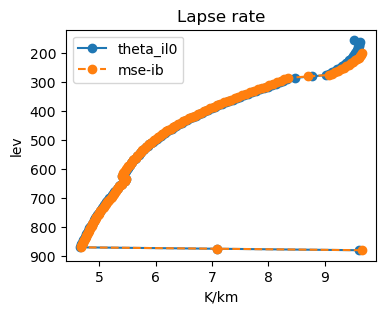

In [25]:
fig, axx = plt.subplots(1, 1, figsize = (4, 3))
ax = axx
# lapse rate
def compute_lapse_rate(ds):
    dp = ds.lev.differentiate('lev')
    RD = 287.04
    GRAVITY = 9.81
    dpdz = -(ds.lev) * GRAVITY / (RD * ds.Tv_plume)
    lapse_rate = -ds.T_plume.differentiate('lev') * dpdz * 1e3 # K/km
    return lapse_rate

lr = {k : compute_lapse_rate(ds[k]) for k in ds.keys()}

(lr['theta_il0']).isel(time = 0).plot(y = 'lev', yincrease = False, marker = 'o')
# (lr['theta_e']).isel(time = 0).plot(y = 'lev', yincrease = False, marker = 'o')
(lr['mse-ib']).isel(time = 0).plot(y = 'lev', yincrease = False, linestyle =  '--', marker = 'o')
ax.legend(['theta_il0', 'mse-ib'])
ax.set_title('Lapse rate')
ax.set_xlabel('K/km')


### Testing 

In [12]:
importlib.reload(PlumeModel)
ti = PlumeModel.TestInversion(**kwargs)

In [13]:
import numpy as np
it = 0
iz = 0

# find first non-nan value in each column
Tbase = ti.T[it, :]
T0 = ti.T[it, ~np.isnan(Tbase)][iz]
q0 = ti.q[it, ~np.isnan(Tbase)][iz]
lev = ti.lev[~np.isnan(Tbase)]
theta0 = ti.theta_il_calc(lev[0], T0 , q0, 0, 0)

for i in range(20):
    T, q, ql, qi = ti.invert_phi(lev[i], theta0, q0, T0)


/home/fiaz/plume_model/PlumeModel.py:349: RuntimeWarning: divide by zero encountered in double_scalars
  return ( (T - T1)/(T2 - T1) ) * np.heaviside((T - T1)/(T2 - T1), 1) * np.heaviside((1 - (T - T1)/(T2 - T1)), 1) + np.heaviside(-(1 - (T - T1)/(T2-T1)),1)
/home/fiaz/plume_model/PlumeModel.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return ( (T - T1)/(T2 - T1) ) * np.heaviside((T - T1)/(T2 - T1), 1) * np.heaviside((1 - (T - T1)/(T2 - T1)), 1) + np.heaviside(-(1 - (T - T1)/(T2-T1)),1)


In [14]:
#LAPSE RATE FOR A SATURATED PARCEL
def moistlift(T, qv, qvv, qt, const):
    
    #CONSTANTS
    cp, cpv, cpl, cpi = const['cp'], const['cpv'], const['cpl'], const['cpi']
    xlv, xls = const['xlv'], const['xls']
    g, ttrip = const['g'], const['ttrip']
    Rd, Rv, epsilon = const['Rd'], const['Rv'], const['epsilon']

    qvv = qvv / (1 - qt)  # FA

    qt = max(qt, 0.0)
    qv = max(qv, 0.0)
    
    cpm_mod = cp + qv * cpv + ( qt - qv ) * cpl 

    Lv = xlv + ( T - ttrip ) * (cpv - cpl)

    L_M_mod = Lv * qvv #/ (1 - Qvsl) #+ (Lv + Li) * OMEGA * qvi / (1 - Qvsi)

    term2_mod = - qvv * (Lv ) * g / ( Rv * T )    
    term3 = -g
    term6_mod = cpm_mod
    term8_mod = ( Lv ) * ( L_M_mod /(Rv * pow(T,2)) )

    gamma_m = ( term2_mod + term3 ) / (term6_mod +  term8_mod)
    
    return gamma_m

In [17]:
from copy import deepcopy
z0 = jp_pm.z[it, ~np.isnan(Tbase)]

def jp_lr(T0, qt0, q0, z0, lev, indx, qsat_prev):

    rsat = jp_pm.compute_rsat(T0, lev[indx], 1)
    q_sat = ( 1 - qt0 ) * rsat
    delta_z = z0[indx + 1] - z0[indx]

    if q0 < q_sat:

        dlapse_rate = jp_pm.drylift(T0, qt0, T0, q0, 0) 
        Tnext = T0 + delta_z * dlapse_rate
        qtnext = qt0
        qnext = q0
        q_sat = (1 - qt0) * jp_pm.compute_rsat(Tnext, lev[indx + 1], 0)

        if qtnext > q_sat:
            satrat = (qtnext - qsat_prev) / ( q_sat - qsat_prev )
            dz_dry = satrat * delta_z
            dz_wet = (1 - satrat) * delta_z

            T_half =  T0 + dz_dry * dlapse_rate
            q_half = q0
            Qt_half = qtnext
            p_half =  lev[indx] * satrat + lev[indx+1] * ( 1 - satrat )

            qvv = (1 - Qt_half) * jp_pm.compute_rsat(T_half, p_half, 0)
            gamma_m = moistlift(T_half, q_half, qvv, Qt_half, jp_pm.const)

            Tnext = T_half + dz_wet * gamma_m
            qtnext = qt0
            qnext  = ( 1 - qtnext ) * jp_pm.compute_rsat(Tnext, lev[indx + 1], 0)

            if qnext > qtnext:
                qnext = qtnext

        q_sat_prev = q_sat

    else:
        qvv = (1 - qt0) * jp_pm.compute_rsat(T0, lev[indx], 0)
        gamma_m = moistlift(T0, q0, qvv, qt0, jp_pm.const)
        Tnext = T0 + delta_z * gamma_m
        qtnext = qt0
        q_sat_prev = (1 - qtnext) * jp_pm.compute_rsat(Tnext, lev[indx + 1], 0)
        qnext = q_sat_prev

        if qnext > qtnext:
            qnext = qtnext

    return Tnext, qtnext, qnext, q_sat_prev

Tin = deepcopy(T0)
qtin = deepcopy(q0)
qin = deepcopy(q0)
qsat_prev = 0

T_mse_ib = []
T_theta_il = []
q_mse_ib = []
q_theta_il = []
qsat_mse_ib = []
qsat_theta_il = []

T_mse_ib.append(Tin)
T_theta_il.append(T0)

q_mse_ib.append(qin)
q_theta_il.append(q0)

qsat0 = (1 - q0) * jp_pm.compute_rsat(T0, lev[0], 0)
qsat_mse_ib.append(qsat0)

qsat0 = ti.qs_calc(lev[0], T0)
qsat_theta_il.append(qsat0)


for i in range(10):
    Tin, qtin, qin, qsat_prev = jp_lr(Tin, qtin, qin, z0, lev, i, qsat_prev)
    T, q, ql, qi = ti.invert_phi(lev[i+1], theta0, q0, T)
    T_mse_ib.append(Tin)
    T_theta_il.append(T)
    q_mse_ib.append(qin)
    q_theta_il.append(q)
    qsat_mse_ib.append(qsat_prev)
    qsat_theta_il.append(ti.qs_calc(lev[i+1], T))
    

/home/fiaz/plume_model/PlumeModel.py:349: RuntimeWarning: divide by zero encountered in double_scalars
  return ( (T - T1)/(T2 - T1) ) * np.heaviside((T - T1)/(T2 - T1), 1) * np.heaviside((1 - (T - T1)/(T2 - T1)), 1) + np.heaviside(-(1 - (T - T1)/(T2-T1)),1)
/home/fiaz/plume_model/PlumeModel.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return ( (T - T1)/(T2 - T1) ) * np.heaviside((T - T1)/(T2 - T1), 1) * np.heaviside((1 - (T - T1)/(T2 - T1)), 1) + np.heaviside(-(1 - (T - T1)/(T2-T1)),1)


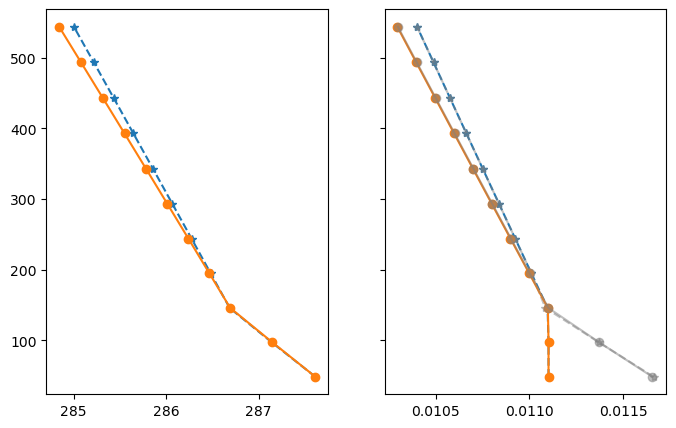

In [18]:
fig, axx = plt.subplots(1, 2, sharey = True, figsize = (8,5))
ax = axx[0]
ax.plot(T_mse_ib, z0[:11], linestyle = 'dashed', marker = '*')
ax.plot(T_theta_il, z0[:11], marker = 'o')

ax = axx[1]
ax.plot(q_mse_ib, z0[:11], linestyle = 'dashed', marker = '*')
ax.plot(qsat_mse_ib, z0[:11], linestyle = 'dashed', marker = '*', color = 'gray', alpha = 0.5)

ax.plot(q_theta_il, z0[:11], marker = 'o')
ax.plot(qsat_theta_il, z0[:11], marker = 'o', color = 'gray', alpha = 0.5)